# Milestone 3

In Milestone 1, our goal was to analyze the influence of ecological scandals on the society. After the review of the assistant, we have thought to slightly change the objective after our first analysis of the dataset. Indeed it was quite difficult to precisely define "ecological scandal" regarding the Gdelt dataset. Moreover, we had to define a precise metric of the "influence" which is quite troublesome. It would have required to do clustering or classification in a more detail manner. Thus, taking into account the timeline for the project, we deem wise to change the objectives of the project.


With the advice of the TA, we have chosen to enlarge the theme to "Environment" and our goal is now to analyse how media covers environment relate events in the world. We would like to know the principal actors, events, the impact on politics or economy of environment issues from the news point of view.
**As such, we have updated the description and the research questions of the ReadMe.
We have explicited what we would like to do in each question and we invite the reader to first read these questions.**


We present here the pipeline we have adopted to answer these questions.


After Milestone 2, the TA suggest us to precie the [ReadMe](../README.md) with information about the used external datasets. We invite the reader to read this new ReadMe. We have also used the human development index as a measure of the development of a country. Moreover, we have continued answering the research questions as well as clarifiying some points, in particular the difference between the location of the event and the location of a news source.

### The data itself
Gdelt files do not contain the name of the columns, so from the GDELT documentation we have built pyspark schemas to be able to use meaningful names in our queries and preprocessing scripts.

Gdelt documentation:

**[GlobalKnowledgeGraph (GKG) V2.1](http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.1.pdf)**

**[GdeltEventDatabase V2.0](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf)**

**[Mention Table](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf)**

As said in the ReadMe, in order to filter the dataset and keep only the environment-related events we keep the items in GKG that contains one of the following tag in their V1THEMES field:
- ```ENV_[*]```: Everything related to environment (from biofuels to overfishing, solar energy, nuclear energy, deforestation...)
- ```SELF_IDENTIFIED_ENVIRON_DISASTER```: Articles where the text explicitly mentions "ecological disaster", "environmental catastrophe", etc
- ```NATURAL_DISASTER```: From floods to coldsnaps, wildfires to tornadoes
- ```MOVEMENT_ENVIRONMENTAL```: Environmental movements

**The [configuration file](cluster/config.py) shows the name and type of the different columns of the dataset as well as the Themes we have kept.**

We then join with the Mention table on the V2DOCUMENTIDENTIFIER mention and then we join the Mention table with GdeltEvent on GLOBALEVENTID to keep the environment-related events.


Moreover, the gdelt dataset contain a lot of null values. We need to keep this in mind when doing computation and fill in or filter this null values.


### Use of the cluster to reduce the dataset size (Milestone 2)
The entire Gdelt database available in the cluster is of TB. This is an enormous amount of data to deal with. Therefore, the first thing to do is to reduce the amount of data we are working on. Here we have used the cluster impressive processing power and memory to come up with parquet files that are treatable on our local machines. To this extent, we have to filtered out unnecessary columns (that is columns we will definitely not us in our analysis) but more importantly we need to filtered out information unrelated to environment.

We have written functions in [load_datasets.py](cluster/load_datasets.py) to load the different csv files for gkg, events and mentions and properly parse them with regards to the columns names. Then we drop out unwanted columns. 

For the gkg files, we first keep only records related to environment by regex filtering on the V1THEMES column. Then we tried to transpose the environment themes present in the V1THEMES to onehot columns (by first exploding this semi-column separated string of themes), but we found that the size of the parquet were to large with this solution. So because knowing which particular theme was present in a record was not important for our first research questions, we decided to simply not put this column in the parquets.

Then using these loading functions, we load ([process_data.py](cluster/process_data.py)) all the csv files and agregate them to three parquets: gkg, mentions and events (mentions are joined with gkg to filter out non-environment-related records and events are joined with the result of the last join).

Size of the parquets:
- GKG: 10.3 GB
- MENTIONS: 3.0 GB
- EVENT: 1.8 GB

### Important remark related to themes filter (after Milestone 2)

We have come up with an important issue while analziny our different visualizations. As described in the previous paragraph, our only filter on "Environment" events was to filter by the V1THEMES and take every line of the gkg files that have a specific theme in this column. However, by doing this, we had taken all the events that could have for instance only a small relation with environment and that have been given an environment label by GDELT. In other words, events that are not really linked to environment but had only one theme related to environment have been considered in our analysis. 

The following histogram shows the distribution of the ratio between themes related to environment over the total number of different themes per gkg line.

![](data/local_generated/env_themes_histogram.png)

We can see that the ratio is concentrated around 0.03. That means we need to fine another way to filter our data and to keep events that are really related to environment.

For this purpose, we saw that the V1Themes column is sorted over the order of appearance of themes in the article. In our case, if an article talk about a environment related issue, then for sure there will be an environment theme among the first themes of V1Themes. We have taken the first five themens of this column to filter the lines in gkg. The scrypt [gkg_env_tag_ratio.py](cluster/gkg_env_tag_ratio.py) does this second filtering. The size of the new GKG parquet is of 2.5 GB.

Finally, all the methods and scripts that were used in Milestone 2 were not modified, we have simply used this new GKG parquet. Concerning the join on mentions and events parquets, we did not have to compute them again, as we could simply join on the GKGRecordId of the new gkg parquet.

### Use of the cluser to get relevant data files

With the three parquets (gkg, mentions and events), we can now perform some computations before coming up with small enough parquets to deal with on local machines. 
Below, you can find the code that has generated the files needed for each of the part that we will discuss next. These files are present in the [data](data/from_cluster) folder.

- *mentions_counts_by_state_and_day_filtered_5themes.csv:* [mentions_counts.py](cluster/mentions_counts.py)
- *tone_mean_count_5themes_median.parquet:* [tone.py](cluster/tone.py)
- *tone_mentions_5themes_europe.parquet* [tone_mentions_europe.py](cluster/tone_mentions_europe.py)

### Use of external datasets and assets

Europe:

- *European countries:* [countries_cleaned_europe.csv](assets/countries_cleaned_europe.csv)
- *FIPS to ISO conversion:* [fips-10-4-to-iso-country-codes](assets/fips-10-4-to-iso-country-codes.csv)
- *European countries geolocalisation:* [europe.geojson](assets/europe.geojson)


Metrics:

- *EPI:* [epi2018countrysnapshotv01.csv](external_datasets/epi2018countrysnapshotv01.csv)
- *HDI:* [human_development_index_2017.csv](external_datasets/human_development_index_2017.csv)

# Analysis of the data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import findspark
findspark.init()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import pyspark
from pyspark.sql import *

In [4]:
spark = SparkSession.builder.getOrCreate()
%matplotlib inline

In [5]:
from local.helper import *

## Major actors

What are the major actors (person, organisation, country) involved in environment-related events?

How strong is the link between them? Is there a type of actor that is more predominant than others?

### Major actors

**TODO Mathieu: méthode**

In [6]:
DATA_PATH = "data/from_cluster/worldcloud_actors/"

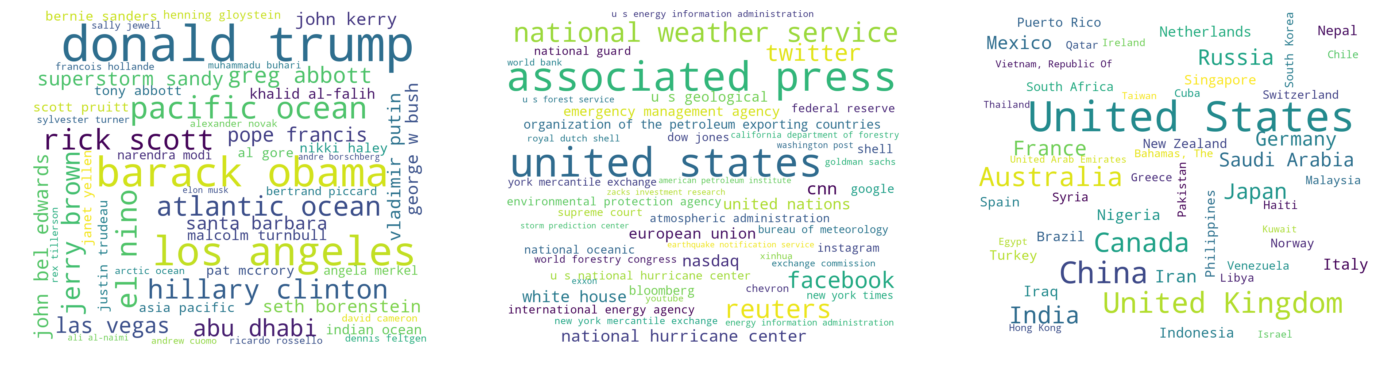

In [16]:
fig = plt.figure(figsize=(24, 8))
wordcloud_persons(DATA_PATH, 50, None, fig, 131)
wordcloud_organizations(DATA_PATH, 50, None, fig, 132)
wordcloud_countries(DATA_PATH, 50, None, fig, 133)

### Links

In [ ]:
# weighted graph

In order to answer this question, we thought it would make sense to count the number of times a person, organisation, and location is mentioned as the first or second actor in an environment-related event. We use the field Actor1TypeCode to discriminate a person (ELI) from an organisation (BUS) from a location (null). ActorType2Code and ActorType3Code are used to identify inside a category, a more precise subtype. For exemple, among the elites we can distinguish a politician from a businessman. 

The end representation we would like to use is a word cloud.

In [ ]:
DATA_FOLDER = 'actors'

In [ ]:
# Load the data
actors_occurences = spark.read.load(DATA_FOLDER + "/actors_occurences.parquet")

We print the top 20 most cited actors, regardless of their category.

In [ ]:
actors_occurences = actors_occurences.sort('Count', ascending=False)
actors_occurences.show(20)

We now discriminate a person (ELI) from an organisation (BUS) from a location (null) since we would like to compare elements that belong to the same category (e.g. e person with another person).

**Elite:** former government officials, celebrities, spokespersons for organizations without further role categorization.

In [ ]:
actors_eli_df = actors_occurences.filter(actors_occurences.Actor1Type1Code=="ELI")
actors_eli_df.show(20)

**Business:** businessmen, companies, and enterprises.

In [ ]:
actors_bus_df = actors_occurences.filter(actors_occurences.Actor1Type1Code=="BUS")
actors_bus_df.show(20)

**Country**

In [ ]:
actors_country_df = actors_occurences.filter("Actor1Type1Code is null")
actors_country_df.show(20)

After having looked at the data, we think that getting the top cited actors with the actor field of the event database is probably not the best way to do. For the business category, we have a lot of results that are irrelevant (for e.g. "company", "bank", "investor"...). We would rather like to have names of actual companies. For the elite category, it's the same thing: "actor", "retired", "United Kingdom" are rather irrelevant. We would prefer to have names of actual persons. 
For this we think it could be better to use the V1LOCATIONS, V1PERSONS and V1ORGANIZATIONS of the GKG database. This is the option we are going to explore next. Otherwise, we will have to manually filter out the names of actors.

## Temporal Approach

What is the evolution in time of the worldwide news coverage (proportion of mentions and tone) of environment-related events?

What are the major recent events related to environment?

### Evolution of Tone

Here we analyse the tone of the news of environment-related events in the world. Gdelt has a metric which measures the average “tone” of the document as a whole. This number ranges from -100 (extremely negative) to +100 (extremely positive). Common values range between -10 and +10, 0 indicates neutral.

We want to grasp the tone of these news in the world in a chronological manner to see how these events are perceived during time.

In [2]:
DATA_PATH = "data/from_cluster/"

In [3]:
spark = SparkSession.builder.getOrCreate()

In [44]:
tones_df = spark.read.parquet(DATA_PATH  + "tone_mean_count_5themes_median.parquet")
tones = tones_df.toPandas()
tones.head()

,day,month,year,median_tone
0,3.0,4.0,2015.0,-2.20
1,5.0,11.0,2016.0,-2.03
2,7.0,7.0,2017.0,-2.18
3,8.0,6.0,2015.0,-1.83
4,10.0,5.0,2016.0,-2.00


In [45]:
tones['datetime'] = pd.to_datetime(tones[['year','month','day']])
tones = tones.sort_values(by='datetime')
tones.head()

,day,month,year,median_tone,datetime
912,18.0,2.0,2015.0,-2.78,2015-02-18
435,19.0,2.0,2015.0,-1.88,2015-02-19
722,20.0,2.0,2015.0,-2.21,2015-02-20
592,21.0,2.0,2015.0,-2.00,2015-02-21
65,22.0,2.0,2015.0,-1.72,2015-02-22


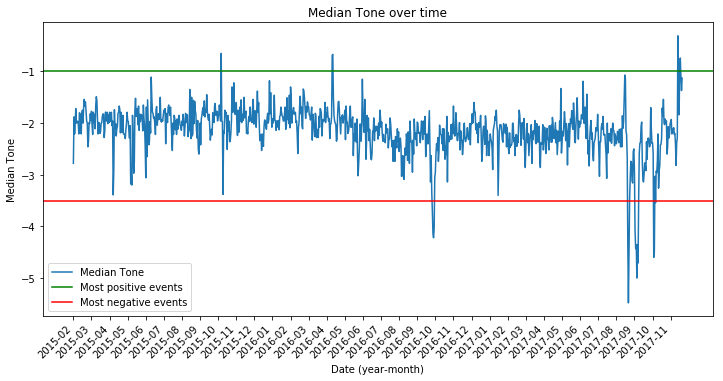

In [46]:
ax = tones.plot('datetime','median_tone',figsize=(12,6), label="Median Tone")
# display a label every month
ticks = tones.datetime.values[0::30]
labels = [str(t).split('-')[0] + "-" + str(t).split('-')[1] for t in ticks]
plt.xticks(ticks, labels, rotation=45)
plt.xlabel("Date (year-month)")
plt.ylabel("Median Tone")
plt.title("Median Tone over time")
plt.axhline(y=-1, color='g',label="Most positive events")
plt.axhline(y=-3.5, color='red', label="Most negative events")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

In [49]:
tones[(tones['median_tone']>-1) & (tones['median_tone']!=0)]

,day,month,year,median_tone,datetime
905,21.0,10.0,2015.0,-0.65,2015-10-21
527,22.0,4.0,2016.0,-0.69,2016-04-22
134,23.0,4.0,2016.0,-0.67,2016-04-23
650,16.0,11.0,2017.0,-0.31,2017-11-16
904,19.0,11.0,2017.0,-0.96,2017-11-19
827,20.0,11.0,2017.0,-0.74,2017-11-20


In [33]:
tones[tones['median_tone']<-3.5]

,day,month,year,median_tone,datetime
937,5.0,10.0,2016.0,-3.70,2016-10-05
852,6.0,10.0,2016.0,-4.14,2016-10-06
342,7.0,10.0,2016.0,-4.22,2016-10-07
866,8.0,10.0,2016.0,-4.04,2016-10-08
274,25.0,8.0,2017.0,-4.35,2017-08-25
750,26.0,8.0,2017.0,-5.48,2017-08-26
764,27.0,8.0,2017.0,-4.50,2017-08-27
336,6.0,9.0,2017.0,-4.08,2017-09-06
14,7.0,9.0,2017.0,-4.43,2017-09-07
572,8.0,9.0,2017.0,-4.36,2017-09-08


From this curve and previous analysis, we can see that the mean tone is around -2.2. The negative value is predictable as environment related events are most often related to bad events inducing negative reaction from the public, thus from the news.
What is more important here is the few peaks (such as on 02.2015, 10.2015 or 01.2016) that we can clearly distinguish on the curve. These surely corresponds to particular events which have attracted the attention of the world scene. From the dates, we can further analyse which event correspond to these peaks. To this extent, we have planned to make a word cloud of the person, organisation and country related to these time peak. We can then confirm by looking at wikipedia for instance. This will be an analysis done for the milestone 3.

### Evolution of Mentions

## Spatial Approach

What is the proportion of mentions and the tone used for environment-related event happening in countries (case-study of European countries)?

Is there any relationship between the economy and the news coverage of environment in countries? Find whether there is a relationship between the previous metrics (proportion of mention and tone) that characterizes the news coverage of environment and the economy of a country.

What is the attention of a specific region of the world on the events occuring in the world? For a given region, we would like to visualize the attention of this region on the events occuring in the entire world. This will be a flip point of view compared to the previous questions (where it was more about how the world sees a specific country).

### European countries 

In [ ]:
DATA_FOLDER = "mentions_counts/"

#### Load countries file

Because GDELT use the FIPS10-4 standard to represent the countries codes, we needed a way to translate them. To this end we use two datasets, one containing all the countries in the world and an another the mapping between ISO and FIPS standards.

In [ ]:
countries = pd.read_csv(DATA_FOLDER+"countries.csv")[["ISO", "Country", "Region"]]
countries.ISO = countries.ISO.str.upper()
countries.set_index("ISO", inplace=True)

regions = countries.Region.unique()[:-1]
print("Regions list:", regions)

fips_to_iso = pd.read_csv(DATA_FOLDER+"fips-10-4-to-iso-country-codes.csv")
countries = countries.merge(fips_to_iso, how="left", left_index=True, right_on="ISO")
countries.drop(columns=["Name"], inplace=True)
countries.dropna()

countries.head(10)

### Compute ratio of counts of mentions (environment/global)

The file ``mentions_counts_by_state_and_day.csv`` was computed on the cluster by aggregating by state and day all the mentions related to environmental events.
This allowed us to compute the proportion of environment related mentions over all mentions.

In [ ]:
counts_file = DATA_FOLDER+"mentions_counts_by_state_and_day.csv"

In [ ]:
def read_csv(path, states=None):
    counts = pd.read_csv(path)
    counts = counts.merge(countries[["Country", "ISO", "FIPS", "Region"]], how="inner", left_on="STATE", right_on="FIPS")
    counts.dropna(inplace=True)
    counts = counts.assign(DATE=pd.to_datetime(counts[["YEAR", "MONTH", "DAY"]]))
    if states is not None:
        counts = counts[counts.STATE.isin(states)]

    counts.drop(columns=["FIPS", "YEAR", "MONTH", "DAY"], inplace=True)
    counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
    counts = counts[["DATE", "STATE", "ISO", "Country", "Region", "GLOBAL_COUNT", "ENV_COUNT", "Ratio"]]
    return counts

### Evolution in time of the ratio of environment related mentions in the world

Here we computed this worldwide ratio for each days over the time period covered of the data that are on the cluster

In [ ]:
counts = read_csv(counts_file)
counts = counts.groupby(["DATE"]).sum()
counts = counts.reset_index()
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.describe()

In [ ]:
ax = counts.plot.line(x="DATE", y=["Ratio"], figsize=(12, 6), legend=None, grid=True,
                 title="Evolution of the ratio of environment related mentions")
ax.set_ylabel("Ratio")

In [ ]:
counts[counts.Ratio>0.47].sort_values("Ratio", ascending=False)

From the descriptive statistics, we can see that the environmental mentions accounts for approximately a quarter of all mentions.

The graph has some surges at specific dates. A rapid check on Wikipedia show that our aggreagation seems to be correct:
- The increase of the ratio in September 2017 correspond to the period during which a hurricane occurred on the east coast of the United States.
- On January 6, 2016, North Korea made a nuclear explosion test, which correspond to the surge occuring on the 3rd.

As for the tone, we plan to make a word cloud to identify more precisely the events.

### Place of environment-related event in the worldwide news for European countries

This part is useful to answer the questions on "the spatial approach". In particular, we have the information for all countries and we present here the use-case for European countries.

Here we computed the same ratio for each day but for each contry in the European region, this would allow us to make the choropleth map with the ratio of the coverage of environmental events for each country.

In [ ]:
counts = read_csv(counts_file, countries[countries.Region=="Europe"].FIPS.values)
counts.describe()

In [ ]:
europe_counts = counts.groupby(["ISO", "Country"]).sum()
europe_counts = europe_counts.assign(Ratio=europe_counts.ENV_COUNT/europe_counts.GLOBAL_COUNT)
europe_counts.sort_values("GLOBAL_COUNT", ascending=False).head(20)